# Locking in a Thimoshenko beam

In [9]:
from dolfin import *
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

## Thimoshenko beam model

We consider a shearable (Thimoshenko) linear beam model. We denote by 

- $\theta$ the rotation field,
- $u$ the transverse displacement
- $t$ the thickness.
- $GS$ the shear stiffness
- $EI = \frac{Et^3}{12}$ the bending stiffness
We take the beam of unit length ($L=1$), Young modulus $E=1.$ and Poisson ratio $\nu=0.3$. 
We consider a clamped-clamped beam with uniform transverse load $p$

The energy of the beam is 

$$
\mathcal E(u,\theta) = \int_0^L \frac{EI}{2}\theta'(x)^2\mathrm{dx} + \int_0^L \frac{GS}{2}(u'(x)-\theta(x))^2\mathrm{dx} - \int_0^L {p^*}\, u(x)\mathrm{dx} 
$$
which can be rewritten in the following nondimensional form
$$
\mathcal E(u,\theta) = \int_0^1 \frac{\theta'(x)^2}{2}\mathrm{dx} + \frac{1}{4(1+\nu)}\int_0^1 \frac{L^2}{t^2}(u'(x)-\theta(x))^2\mathrm{dx} - \int_0^1 p\, u(x)\mathrm{dx} 
$$
where  $p=\frac{{{p^*}}\,L^3}{EI}$
The boundary conditions are $u(0)=u(L)=0$, $\theta(0)=\theta(L)=0$.

## Locking 

For $t/L\to 0$, the solution should respect the constraint $u'(x)=\theta(x), \forall x$. This constraint may create issues in the finite element discretisation. 
Consider for example a discretisation with $u \in P_1$ and $\theta \in P_1$. Then  $u'(x)$ should be piecewise constant. In the limit $t\to0$, $\theta(x)=u'(x)$. Hence $\theta$ should be then constant in each element and continous. Since it is 0 in $x=0$, then it must be zero everywhere. Obviousvly this is not the exact solution. Because of the constraint the finite element discretisation is not able to correctly represent the solution. This is the **locking issue**. 

## Beam solver
Below a solver for the Thimoshenko beam using FEniCS (and an utility function for plotting)

In [10]:
def beam_solver(n, t, element_u, element_theta):
    mesh = UnitIntervalMesh(n)
    # Create a "mixed" element collecting the u and theta fields
    element = MixedElement([element_u, element_theta])
    # Create the function space
    V = FunctionSpace(mesh, element)
    u_, theta_ = TrialFunctions(V)
    u_t, theta_t = TestFunctions(V)
    # Define the variational problem
    E = 1.; nu = 0.3
    G = E/(2*(1+nu))
    t = Constant(t)
    EI = E*t**3/12.
    GS = G*t
    a = EI*(theta_.dx(0)*theta_t.dx(0))*dx + GS*((u_.dx(0)-theta_)*(u_t.dx(0)-theta_t))*dx
    p = Constant(1.*t**3)
    L = p*u_t*dx
    bc = DirichletBC(V, (0,0), "on_boundary")
    # Solve the problem
    utheta = Function(V)
    solve(a==L,utheta,bc, solver_parameters={"linear_solver": "lu"})
    # Extract the subfunctions
    u, theta = utheta.split(deepcopy=True)
    return (u,theta)

def plot_beam(u,theta):
    mesh = u.function_space().mesh()
    plt.plot(mesh.coordinates()[:,0], u.compute_vertex_values(),"bo-", label = "u")
    plt.plot(mesh.coordinates()[:,0], theta.compute_vertex_values(),"g^-", label = "theta")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.legend()

Here the solution for 20 element and thickness $t=0.01$ 

### P1-P1
The displacement is "too small"

<IPython.core.display.Javascript object>


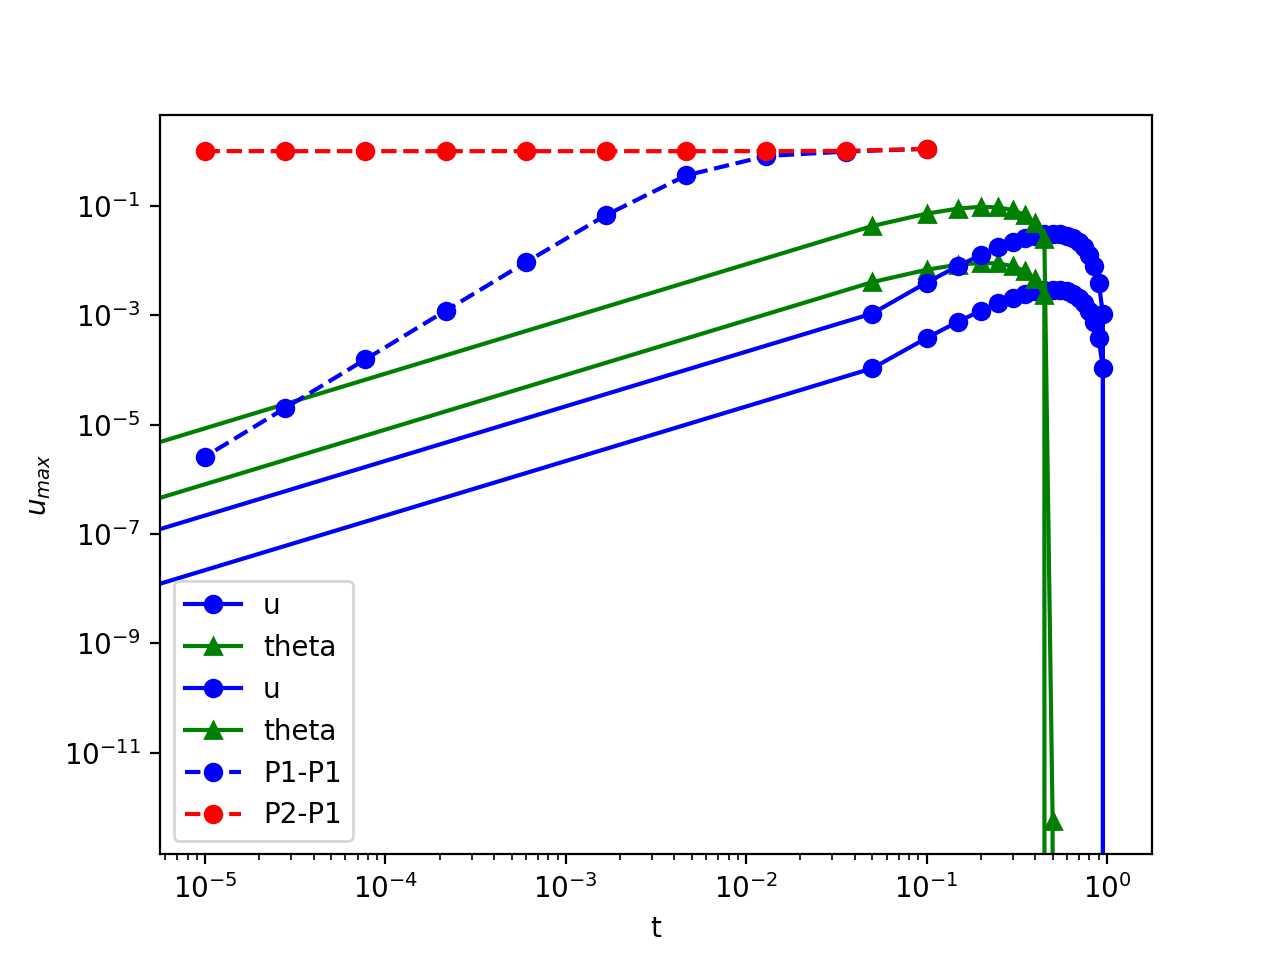

u_FE = 0.002947,  u_EX = 0.031250,  error (percent) =  -90.569913


In [11]:
element_u = FiniteElement('P', interval, 1) 
element_theta = FiniteElement('P', interval, 1) 
u, theta = beam_solver(20, .01, element_u, element_theta)
plot_beam(u, theta)
u_ex = 1./32. # p*length**2/(384.*EI)
print("u_FE = %f, " %u.vector().max(), "u_EX = %f, "%u_ex, "error (percent) =  %f"%(100*(u.vector().max()/u_ex-1)))

### P2-P1
Ok with analytical solution

In [12]:
element_u = FiniteElement('P', interval, 2) 
element_theta = FiniteElement('P', interval, 1) 
u, theta = beam_solver(20, .01, element_u, element_theta)
plot_beam(u, theta)
print("u_FE = %f, " %u.vector().max(), "u_EX = %f, "%u_ex, "error (percent) =  %f"%(100*(u.vector().max()/u_ex-1)))
u_ex = 1./32. # p*length**2/(384.*EI)
print()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/maurini/.fenics/fenics-2018.1/lib/python3.7/site-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/maurini/.fenics/fenics-2018.1/lib/python3.7/site-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


u_FE = 0.030970,  u_EX = 0.031250,  error (percent) =  -0.896000



## Dependence on thickness

The numerical results clear shows locking for $P_1-P_1$:
the exact solution should not depend on $t$ for $t\ll 1$. 

In [13]:
ts = np.logspace(-1,-5,10)
n  = 100
umaxs_1 = 0.*ts
umaxs_2 = 0.*ts
# dependence on t for P1-P1
element_u = FiniteElement('P', interval, 1) 
element_theta = FiniteElement('P', interval, 1) 
for (i,t) in enumerate(ts):
    u, theta = beam_solver(n, t, element_u, element_theta)
    umaxs_1[i] = u.vector().max()
#  dependence on t for P2-P1
element_u = FiniteElement('P', interval, 2) 
element_theta = FiniteElement('P', interval, 1) 
for (i,t) in enumerate(ts):
    u, theta = beam_solver(n, t, element_u, element_theta)
    umaxs_2[i] = u.vector().max()
# plot
plt.loglog(ts,umaxs_1/u_ex,'bo--', label = "P1-P1")
plt.loglog(ts,umaxs_2/u_ex,'ro--', label = "P2-P1")
plt.xlabel("t")
plt.ylabel(r"$u_{max}$")
plt.legend()

### Dependence on mesh

Lets see the convergence on the mesh for difference thickness. 
$P_1-P_1$ converges to the solution, but extremely slowly for small thicknness. This makes the element not usable. 

<IPython.core.display.Javascript object>


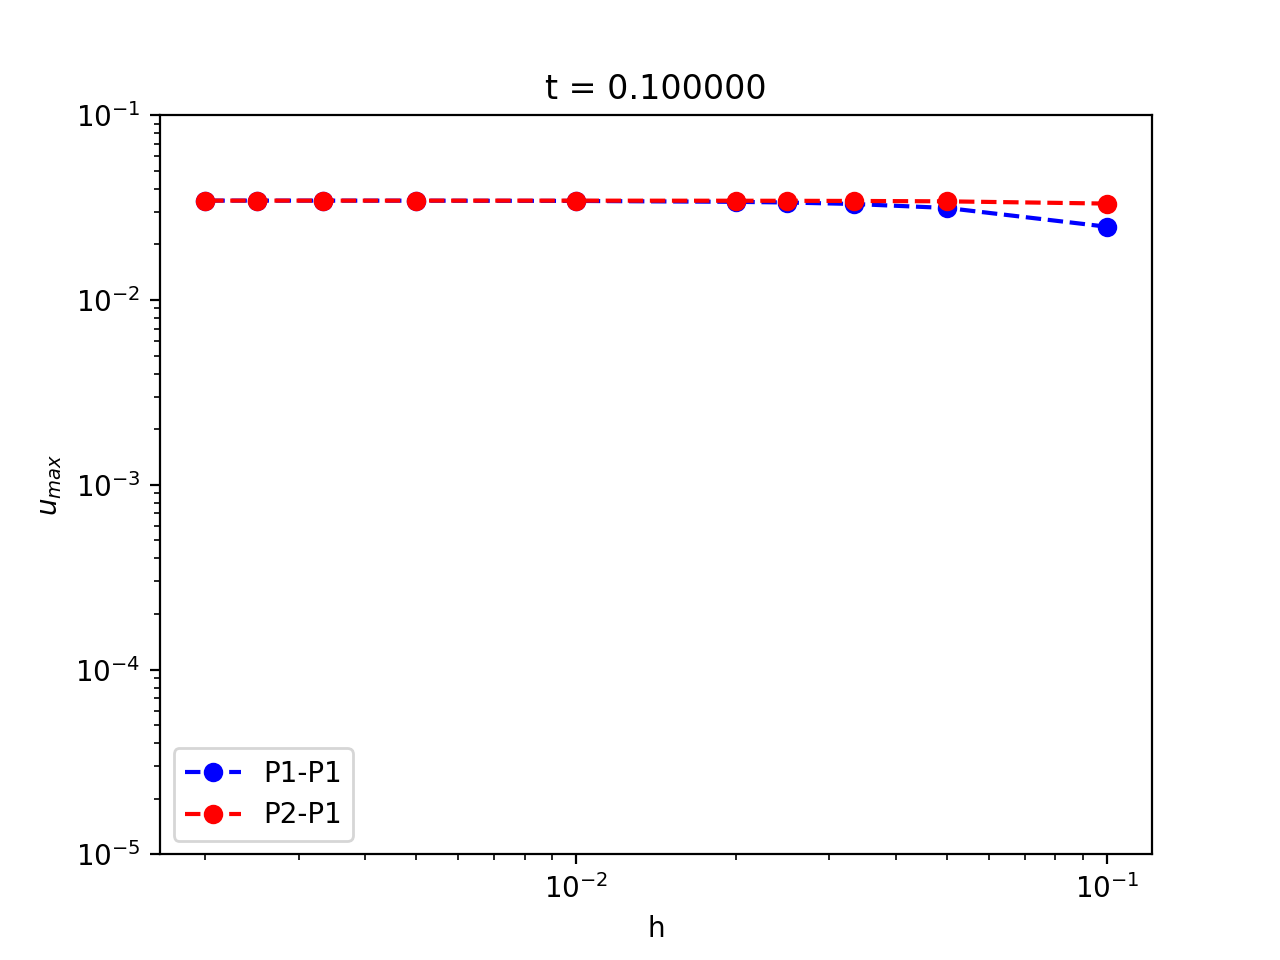

<IPython.core.display.Javascript object>


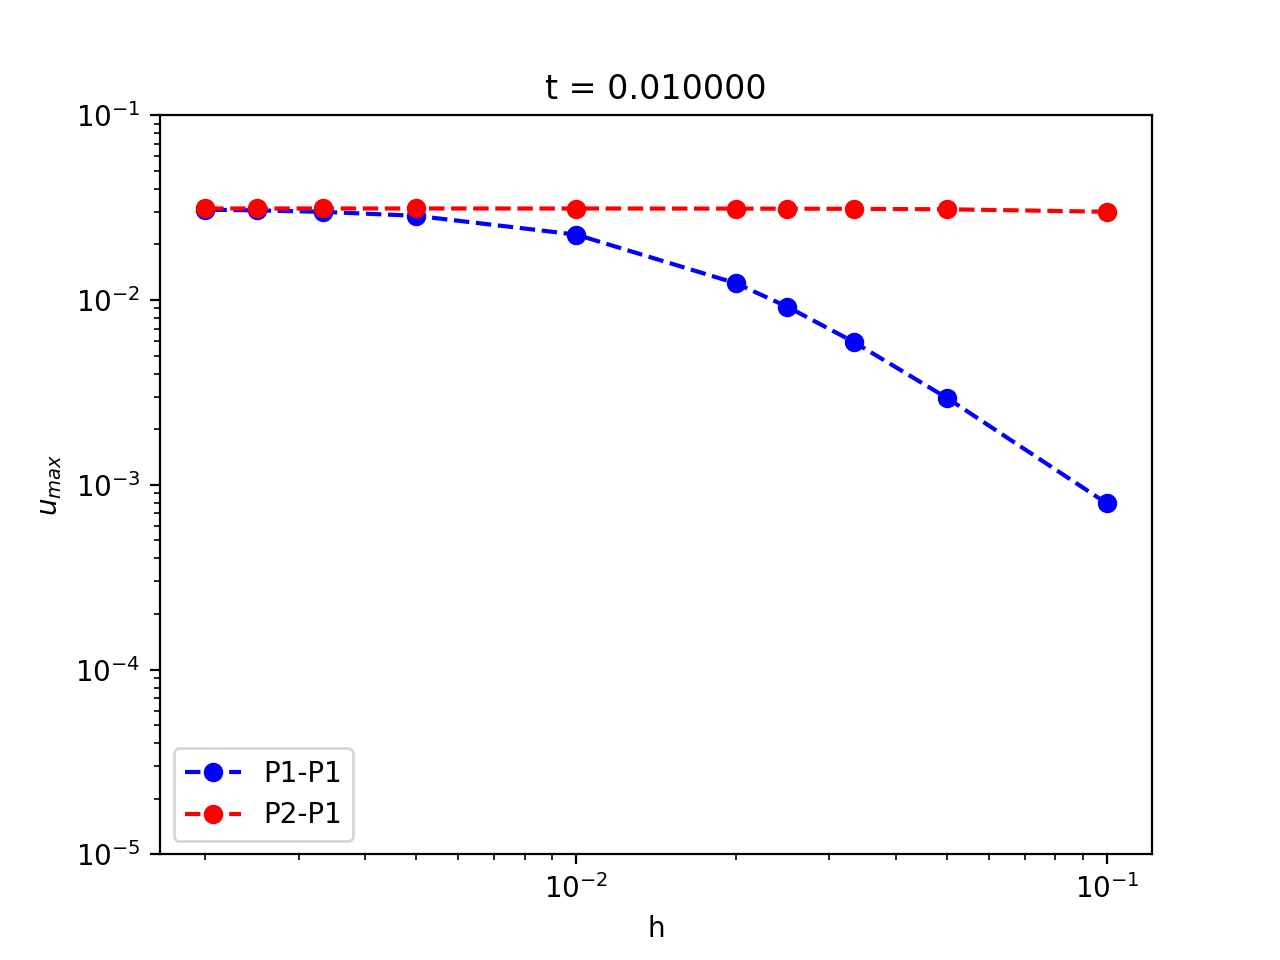

<IPython.core.display.Javascript object>


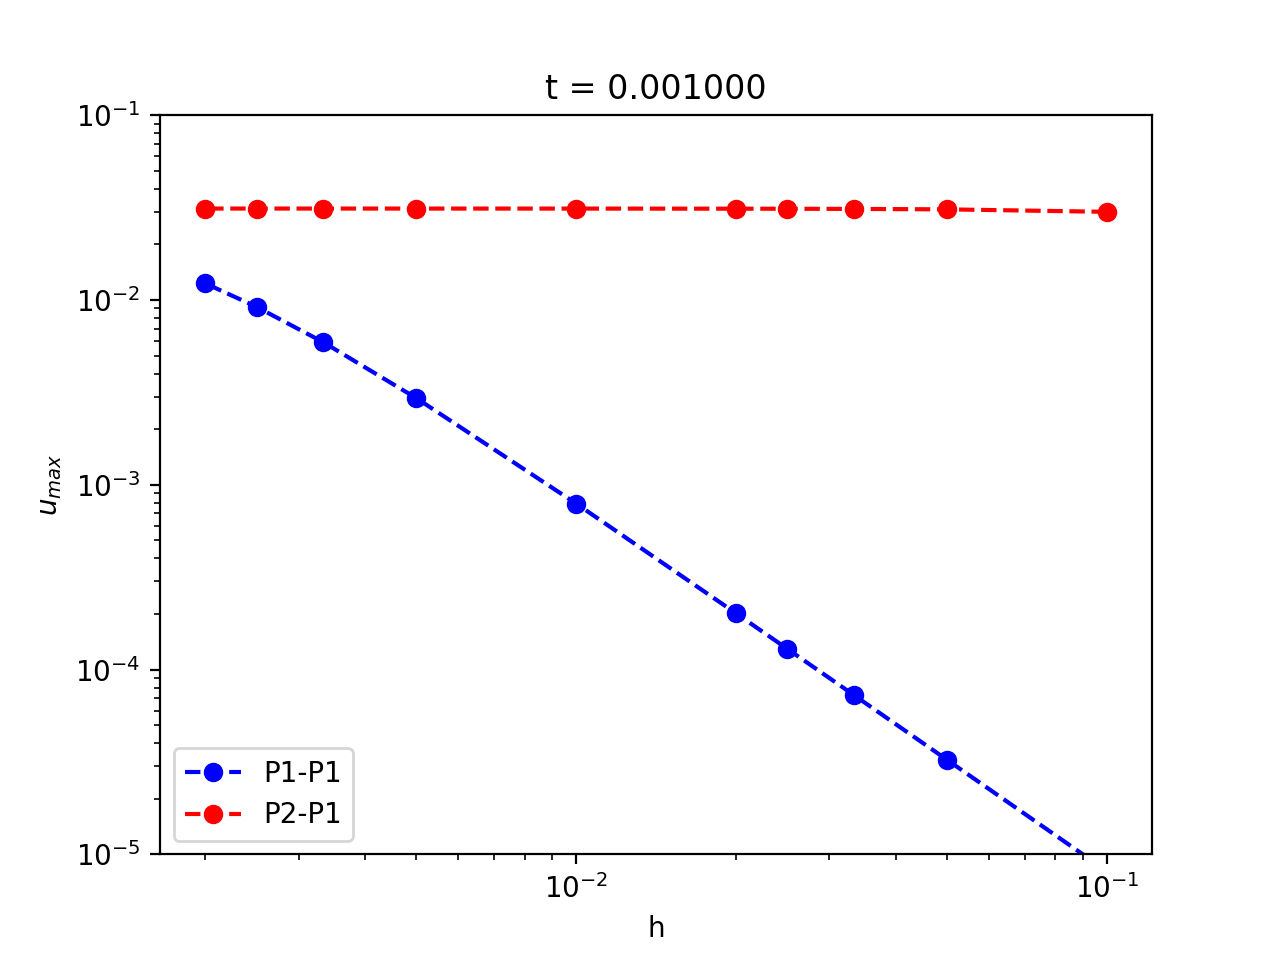

In [14]:
for t in [0.1,0.01,0.001]:
    ns = [10,20,30,40,50,100,200,300,400,500]
    umaxs_1 = np.zeros(len(ns))
    umaxs_2 = np.zeros(len(ns))
    # dependence on t for P1-P1
    element_u = FiniteElement('P', interval, 1) 
    element_theta = FiniteElement('P', interval, 1) 
    for (i,n) in enumerate(ns):
        u, theta = beam_solver(n, t, element_u, element_theta)
        umaxs_1[i] = u.vector().max()
    #  dependence on t for P2-P1
    element_u = FiniteElement('P', interval, 2) 
    element_theta = FiniteElement('P', interval, 1) 
    for (i,n) in enumerate(ns):
        u, theta = beam_solver(n, t, element_u, element_theta)
        umaxs_2[i] = u.vector().max()
    # plot
    plt.figure()
    plt.loglog(1./np.array(ns),umaxs_1,'bo--', label = "P1-P1")
    plt.loglog(1./np.array(ns),umaxs_2,'ro--', label = "P2-P1")
    plt.xlabel("h")
    plt.ylabel(r"$u_{max}$")
    plt.legend()
    plt.ylim([1.e-5,1.e-1])
    plt.title("t = %f"%t)

## Conclusion 
For the case of the linear shearable beam, the locking is easily solved by using $P_2-P_1$ discretisation.
Solving the locking issue can be tricker in other cases.

### A question
Is this result in constrast with *a priori* estimates in FE?